In [16]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath(os.path.expanduser("~/Code/Python/Mask_RCNN/"))

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from utils import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from samples.YCB_Video.Test_Pose_Estimation import calculate_2d_hull_of_pointcloud, load_YCB_meta_infos
import mrcnn.model as modellib
from mrcnn.data_generation import load_image_gt
from mrcnn.model import log
from mrcnn.pointnet_pose_estimation import build_fpn_pointnet_pose_graph
from mrcnn.Chamfer_Distance_Loss import mrcnn_pose_loss_graph_keras
import open3d as o3d
import keras as k


In [17]:

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_ycbv_pose_estimation_test_1.h5")
DEBUG = False
if DEBUG:
    import keras.backend as KB
    from tensorflow.python import debug as tf_debug

    sess = tf.Session()
    sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    KB.set_session(sess)

def all_equal(iterator):
  try:
     iterator = iter(iterator)
     first = next(iterator)
     return all(np.array_equal(first, rest) for rest in iterator)
  except StopIteration:
     return True

sys.path.append(os.path.join(ROOT_DIR, "samples/YCB_Video/"))  # To find local version
print(os.path.join(ROOT_DIR, "samples/YCB_Video"))
import samples.YCB_Video.YCB_Video as ycbv

config = ycbv.YCBVConfig()
DATASET_DIR = os.path.join(os.path.expanduser("~"), "Hitachi/YCB_Video_Dataset")  # TODO: enter value here


# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_DEPTH_AWARE_OPS = True
    POSE_ESTIMATION_METHOD = "pointnet"
    POINTNET_VECTOR_SIZE = 1024
    TRAIN_ROIS_PER_IMAGE = 100
    # DETECTION_MIN_CONFIDENCE = 0.0


config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "training"


/home/christoph/Code/Python/Mask_RCNN/samples/YCB_Video

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
ESTIMATE_6D_POSE               True
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                34
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_l

In [18]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


# Build validation dataset

dataset = ycbv.YCBVDataset()
dataset.load_ycbv(DATASET_DIR, "train", use_rgbd=True)
dataset.prepare()

# Create model in inference mode
model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,
                          config=config)

# Load weights
model.load_weights(MODEL_PATH, by_name=True)#, exclude=["mrcnn_pointnet_rot_fc3"])

# ## Run Detection

image_id = random.choice(dataset.image_ids)
# image_id = 95506
info = dataset.image_info[image_id]
image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_pose, intrinsic_matrix_gt = load_image_gt(dataset, config, image_id,
                                                                                   use_mini_mask=False)
intrinsic_matrix, classes, depth_factor, rot_trans_mat, vertmap, poses, center = load_YCB_meta_infos(info["id"])
non_molded_im = dataset.load_image(image_id)


In [19]:
# Run object detection
# if TEST_MODE is "inference":
    # results = model.detect([image], verbose=1)
    #
    # # Display results
    # ax = get_ax(1)
    # r = results[0]
    #
    # visualize.display_instances(image[:, :, :3], r['rois'], r['masks'], r['class_ids'],
    #                             dataset.class_names, r['scores'], ax=ax,
    #                             title="Predictions", poses=r["poses"], intrinsic_matrix=intrinsic_matrix)
    # log("gt_class_id", gt_class_id)
    # log("gt_bbox", gt_bbox)
    # log("gt_mask", gt_mask)
    #
    # activations = model.run_graph([image], [
    #     ("roi_align_pose_image", model.keras_model.get_layer("roi_align_pose").output[0]),
    #     ("roi_align_pose_depth", model.keras_model.get_layer("roi_align_pose").output[1]),
    #     ("rois_trans_deconv", model.keras_model.get_layer("mrcnn_pose_rois_trans_deconv").output),  # for resnet100
    #     ("rois_trans_conv", model.keras_model.get_layer("mrcnn_pose_rois_trans_conv").output),
    #     ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    #     ("pose_conv1", model.keras_model.get_layer("mrcnn_pose_conv1").output),
    #     ("pose_conv4", model.keras_model.get_layer("mrcnn_pose_conv4").output),
    #     ("pose_conv5", model.keras_model.get_layer("mrcnn_pose_conv5").output),
    #     ("trans_conva", model.keras_model.get_layer("mrcnn_pose_trans_conva").output),
    #     ("trans_convb", model.keras_model.get_layer("mrcnn_pose_trans_convb").output),
    #     ("trans_squeeze", model.keras_model.get_layer("mrcnn_pose_trans_squeeze").output),
    #     ("rot_conva", model.keras_model.get_layer("mrcnn_pose_rot_conva").output),
    #     ("rot_convb", model.keras_model.get_layer("mrcnn_pose_rot_convb").output),
    #     ("mrcnn_class", model.keras_model.get_layer("mrcnn_class").output)
    # ])
    # det_class_ids = activations['detections'][0, :, 4].astype(np.int32)
    # class_logits = activations['detections'][0, :, 5].astype(np.int32)

if TEST_MODE is "training":
    activations = model.run_trainings_graph(dataset, image_id, [
        ("rois", model.keras_model.get_layer("proposal_targets").output[0]),
        ("target_class_ids", model.keras_model.get_layer("proposal_targets").output[1]),
        ("target_poses", model.keras_model.get_layer("proposal_targets").output[4]),
        ("mrcnn_class", model.keras_model.get_layer("mrcnn_class").output),
        ("mrcnn_bbox", model.keras_model.get_layer("mrcnn_bbox").output),
        ("mrcnn_class_logits", model.keras_model.get_layer("mrcnn_class_logits").output),
        ######## from function - build_fpn_pointnet_pose_graph ############
        ("pcl_list", model.keras_model.get_layer("FeaturePointCloud").output[0]),
        ("feature_list", model.keras_model.get_layer("FeaturePointCloud").output[1]),
        ("roi_align_pose_image", model.keras_model.get_layer("roi_align_pointnet_pose").output[0]),
        ("roi_align_pose_depth", model.keras_model.get_layer("roi_align_pointnet_pose").output[1]),
        ("expand_pcl_list", model.keras_model.get_layer("expand_pcl_list").output),
        ("expand_feature_list", model.keras_model.get_layer("expand_feature_list").output),
        ("mrcnn_pose_feature_conv", model.keras_model.get_layer("mrcnn_pose_feature_conv").output),
        ("point_cloud_repr_concat", model.keras_model.get_layer("point_cloud_repr_concat").output),
        ("pose_conv1", model.keras_model.get_layer("mrcnn_pointnet_trans_conv1").output),
        ("pose_conv2", model.keras_model.get_layer("mrcnn_pointnet_trans_conv2").output),
        ("pose_conv3", model.keras_model.get_layer("mrcnn_pointnet_trans_conv3").output),
        ("pose_conv4", model.keras_model.get_layer("mrcnn_pointnet_trans_conv4").output),
        ("pose_conv5", model.keras_model.get_layer("mrcnn_pointnet_trans_conv5").output),
        ("sym_max_pool", model.keras_model.get_layer("mrcnn_trans_sym_max_pool").output),
        ("rot_fc1", model.keras_model.get_layer("mrcnn_pointnet_rot_fc1").output),
        ("rot_fc2", model.keras_model.get_layer("mrcnn_pointnet_rot_fc2").output),
        ("rot_fc3", model.keras_model.get_layer("mrcnn_pointnet_rot_fc3").output),
        ("trans_fc1", model.keras_model.get_layer("mrcnn_pointnet_trans_fc1").output),
        ("trans_fc2", model.keras_model.get_layer("mrcnn_pointnet_trans_fc2").output),
        ("trans_fc3", model.keras_model.get_layer("mrcnn_pointnet_trans_fc3").output),
        ("trans_reshape", model.keras_model.get_layer("trans_reshape").output),
        ("rot_reshape", model.keras_model.get_layer("rot_reshape").output),
        # ("calcrotmatrix", model.keras_model.get_layer("CalcRotMatrix").output),
        ########### from function - mrcnn_pose_loss_graph_keras ###########
        ("pose_target_class_ids", model.keras_model.get_layer("mrcnn_pose_loss/target_class_ids").output),
        ("pose_target_poses", model.keras_model.get_layer("mrcnn_pose_loss/target_poses").output),
        ("pose_target_trans", model.keras_model.get_layer("mrcnn_pose_loss/target_trans").output),
        ("pose_target_rot", model.keras_model.get_layer("mrcnn_pose_loss/target_rot").output),
        ("pose_pred_trans", model.keras_model.get_layer("mrcnn_pose_loss/pred_trans_transposed").output),
        ("pose_pred_rot", model.keras_model.get_layer("mrcnn_pose_loss/pred_rot_transposed").output),
        ("pose_positive_ix", model.keras_model.get_layer("mrcnn_pose_loss/positive_ix").output),
        ("pose_positive_class_ids", model.keras_model.get_layer("mrcnn_pose_loss/positive_class_ids").output),
        ("pose_indices", model.keras_model.get_layer("mrcnn_pose_loss/indices").output),
        ("pose_y_true_t", model.keras_model.get_layer("mrcnn_pose_loss/y_true_t").output),
        ("pose_y_true_r", model.keras_model.get_layer("mrcnn_pose_loss/y_true_r").output),
        ("pose_y_pred_t", model.keras_model.get_layer("mrcnn_pose_loss/y_pred_t").output),
        ("pose_y_pred_r", model.keras_model.get_layer("mrcnn_pose_loss/y_pred_r").output),
        # ("pose_pred_rot_svd_matmul", model.keras_model.get_layer("mrcnn_pose_loss/pred_rot_svd_matmul").output),
        ("pose_pos_xyz_models", model.keras_model.get_layer("mrcnn_pose_loss/pos_xyz_models").output),
        ("transl_loss", model.keras_model.get_layer("mrcnn_pose_loss/trans_loss").output),
        ("rot_loss", model.keras_model.get_layer("mrcnn_pose_loss/rot_loss").output),
        # ("total_loss", model.keras_model.get_layer("mrcnn_pose_loss/total_loss").output),
        ########### from function - chamfer_distance_loss_keras ###########
        # ("transposed_pred_models", model.keras_model.get_layer("transposed_pred_models").output),
        # ("added_pred_models", model.keras_model.get_layer("added_pred_models").output),
        # ("transposed_target_models", model.keras_model.get_layer("transposed_target_models").output),
        ("added_target_models", model.keras_model.get_layer("added_target_models").output),
        # ("NNDistance1", model.keras_model.get_layer("NNDistance").output[0]),
        # ("NNDistance2", model.keras_model.get_layer("NNDistance").output[2]),
        # ("reduced_sum1", model.keras_model.get_layer("reduced_mean1").output),
        # ("reduced_sum2", model.keras_model.get_layer("reduced_mean2").output),
        # ("added_reduced_sum", model.keras_model.get_layer("added_reduced_mean").output),
        # ("chamfer_loss", model.keras_model.get_layer("mrcnn_chamfer_loss").output),
        ######## Feature Maps ######
        ("fpn_p2", model.keras_model.get_layer("fpn_p2").output),
        ("fpn_p3", model.keras_model.get_layer("fpn_p3").output),
        ("fpn_p4", model.keras_model.get_layer("fpn_p4").output),
        ("fpn_p5", model.keras_model.get_layer("fpn_p5").output),
        ##### mrcnn_mask ####
        ("mrcnn_mask", model.keras_model.get_layer("mrcnn_mask").output),
        ("mrcnn_mask_deconv", model.keras_model.get_layer("mrcnn_mask_deconv").output),

    ], return_gradients=False)
    weights = model.run_trainings_graph(dataset, image_id, [
        ("rois", model.keras_model.get_layer("proposal_targets").weights),
        ("target_class_ids", model.keras_model.get_layer("proposal_targets").weights),
        ("target_poses", model.keras_model.get_layer("proposal_targets").weights),
        ("mrcnn_class", model.keras_model.get_layer("mrcnn_class").weights),
        ("mrcnn_bbox", model.keras_model.get_layer("mrcnn_bbox").weights),
        ("mrcnn_class_logits", model.keras_model.get_layer("mrcnn_class_logits").weights),
        ######## from function - build_fpn_pointnet_pose_graph ############
        ("pcl_list", model.keras_model.get_layer("FeaturePointCloud").weights),
        ("feature_list", model.keras_model.get_layer("FeaturePointCloud").weights),
        ("roi_align_pose_image", model.keras_model.get_layer("roi_align_pointnet_pose").weights),
        ("roi_align_pose_depth", model.keras_model.get_layer("roi_align_pointnet_pose").weights),
        ("expand_pcl_list", model.keras_model.get_layer("expand_pcl_list").weights),
        ("expand_feature_list", model.keras_model.get_layer("expand_feature_list").weights),
        ("mrcnn_pose_feature_conv", model.keras_model.get_layer("mrcnn_pose_feature_conv").weights),
        ("point_cloud_repr_concat", model.keras_model.get_layer("point_cloud_repr_concat").weights),
        ("pose_conv1", model.keras_model.get_layer("mrcnn_pointnet_trans_conv1").weights),
        ("pose_conv2", model.keras_model.get_layer("mrcnn_pointnet_trans_conv2").weights),
        ("pose_conv3", model.keras_model.get_layer("mrcnn_pointnet_trans_conv3").weights),
        ("pose_conv4", model.keras_model.get_layer("mrcnn_pointnet_trans_conv4").weights),
        ("pose_conv5", model.keras_model.get_layer("mrcnn_pointnet_trans_conv5").weights),
        ("sym_max_pool", model.keras_model.get_layer("mrcnn_trans_sym_max_pool").weights),
        ("rot_fc1", model.keras_model.get_layer("mrcnn_pointnet_rot_fc1").weights),
        ("rot_fc2", model.keras_model.get_layer("mrcnn_pointnet_rot_fc2").weights),
        ("rot_fc3", model.keras_model.get_layer("mrcnn_pointnet_rot_fc2").weights),
        ("trans_fc1", model.keras_model.get_layer("mrcnn_pointnet_trans_fc1").weights),
        ("trans_fc2", model.keras_model.get_layer("mrcnn_pointnet_trans_fc2").weights),
        ("trans_fc3", model.keras_model.get_layer("mrcnn_pointnet_trans_fc3").weights),
        ("trans_reshape", model.keras_model.get_layer("trans_reshape").weights),
        ("rot_reshape", model.keras_model.get_layer("rot_reshape").weights),
        # ("calcrotmatrix", model.keras_model.get_layer("CalcRotMatrix").weights),
        ########### from function - mrcnn_pose_loss_graph_keras ###########
        ("pose_target_class_ids", model.keras_model.get_layer("mrcnn_pose_loss/target_class_ids").weights),
        ("pose_target_poses", model.keras_model.get_layer("mrcnn_pose_loss/target_poses").weights),
        ("pose_target_trans", model.keras_model.get_layer("mrcnn_pose_loss/target_trans").weights),
        ("pose_target_rot", model.keras_model.get_layer("mrcnn_pose_loss/target_rot").weights),
        ("pose_pred_trans", model.keras_model.get_layer("mrcnn_pose_loss/pred_trans_transposed").weights),
        ("pose_pred_rot", model.keras_model.get_layer("mrcnn_pose_loss/pred_rot_transposed").weights),
        ("pose_positive_ix", model.keras_model.get_layer("mrcnn_pose_loss/positive_ix").weights),
        ("pose_positive_class_ids", model.keras_model.get_layer("mrcnn_pose_loss/positive_class_ids").weights),
        ("pose_indices", model.keras_model.get_layer("mrcnn_pose_loss/indices").weights),
        ("pose_y_true_t", model.keras_model.get_layer("mrcnn_pose_loss/y_true_t").weights),
        ("pose_y_true_r", model.keras_model.get_layer("mrcnn_pose_loss/y_true_r").weights),
        ("pose_y_pred_t", model.keras_model.get_layer("mrcnn_pose_loss/y_pred_t").weights),
        ("pose_y_pred_r", model.keras_model.get_layer("mrcnn_pose_loss/y_pred_r").weights),
        # ("pose_pred_rot_svd_matmul", model.keras_model.get_layer("mrcnn_pose_loss/pred_rot_svd_matmul").weights),
        # ("pose_pos_xyz_models", model.keras_model.get_layer("mrcnn_pose_loss/pos_xyz_models").weights),
        # ("transl_loss", model.keras_model.get_layer("mrcnn_pose_loss/transl_error").weights),
        # ("rot_loss", model.keras_model.get_layer("mrcnn_pose_loss/rot_error").weights),
        # ("total_loss", model.keras_model.get_layer("mrcnn_pose_loss/total_loss").weights),
        ########### from function - chamfer_distance_loss_keras ###########
        # ("transposed_pred_models", model.keras_model.get_layer("transposed_pred_models").weights),
        # ("added_pred_models", model.keras_model.get_layer("added_pred_models").weights),
        # ("transposed_target_models", model.keras_model.get_layer("transposed_target_models").weights),
        ("added_target_models", model.keras_model.get_layer("added_target_models").weights),
        # ("NNDistance1", model.keras_model.get_layer("NNDistance").weights[0]),
        # ("NNDistance2", model.keras_model.get_layer("NNDistance").weights[2]),
        # ("reduced_sum1", model.keras_model.get_layer("reduced_mean1").weights),
        # ("reduced_sum2", model.keras_model.get_layer("reduced_mean2").weights),
        # ("added_reduced_sum", model.keras_model.get_layer("added_reduced_mean").weights),
        # ("chamfer_loss", model.keras_model.get_layer("mrcnn_chamfer_loss").weights),
        ######## Feature Maps ######
        ("fpn_p2", model.keras_model.get_layer("fpn_p2").weights),
        ("fpn_p3", model.keras_model.get_layer("fpn_p3").weights),
        ("fpn_p4", model.keras_model.get_layer("fpn_p4").weights),
        ("fpn_p5", model.keras_model.get_layer("fpn_p5").weights),
        ##### mrcnn_mask ####
        ("mrcnn_mask", model.keras_model.get_layer("mrcnn_mask").weights),
        ("mrcnn_mask_deconv", model.keras_model.get_layer("mrcnn_mask_deconv").weights),

    ], return_gradients=False)
    det_class_ids = activations['target_class_ids'][0].astype(np.int32)
k.losses.mse
intrinsic_matrix, classes, depth_factor, rot_trans_mat, vertmap, poses, center = load_YCB_meta_infos(info["id"])

rois                     shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32
target_class_ids         shape: (1, 100)              min:    0.00000  max:   15.00000  int32
target_poses             shape: (1, 100, 4, 4)        min:   -0.90954  max:    1.00000  float32
mrcnn_class              shape: (1, 100, 22)          min:    0.00000  max:    1.00000  float32
mrcnn_bbox               shape: (1, 100, 22, 4)       min:   -4.01365  max:    3.39178  float32
mrcnn_class_logits       shape: (1, 100, 22)          min:   -8.49937  max:   19.72443  float32
pcl_list                 shape: (1, 100, 324, 3)      min:   -0.56390  max:    2.35000  float32
feature_list             shape: (1, 100, 324, 256)    min:   -7.00619  max:    7.57145  float32
roi_align_pose_image     shape: (1, 100, 18, 18, 256)  min:   -7.00619  max:    7.57145  float32
roi_align_pose_depth     shape: (1, 100, 18, 18, 1)   min:    0.00000  max:    2.35000  float32
expand_pcl_list          shape: (1, 100, 

mrcnn_class_logits_0     shape: (1024, 22)            min:   -0.44476  max:    0.54823  float32
mrcnn_class_logits_1     shape: (22,)                 min:   -0.41268  max:    0.48506  float32
mrcnn_pose_feature_conv_0shape: (1, 64, 1, 1)         min:   -0.31255  max:    0.26135  float32
mrcnn_pose_feature_conv_1shape: (1,)                  min:    0.02706  max:    0.02706  float32
pose_conv1_0             shape: (1, 2, 1, 16)         min:   -1.52657  max:    1.37927  float32
pose_conv1_1             shape: (16,)                 min:   -0.49880  max:    0.27644  float32
pose_conv2_0             shape: (1, 3, 16, 32)        min:   -0.47294  max:    0.62647  float32
pose_conv2_1             shape: (32,)                 min:   -0.28533  max:    0.36016  float32
pose_conv3_0             shape: (1, 4, 32, 64)        min:   -0.34425  max:    0.42147  float32
pose_conv3_1             shape: (64,)                 min:   -0.19182  max:    0.23373  float32
pose_conv4_0             shape: (1, 1, 6

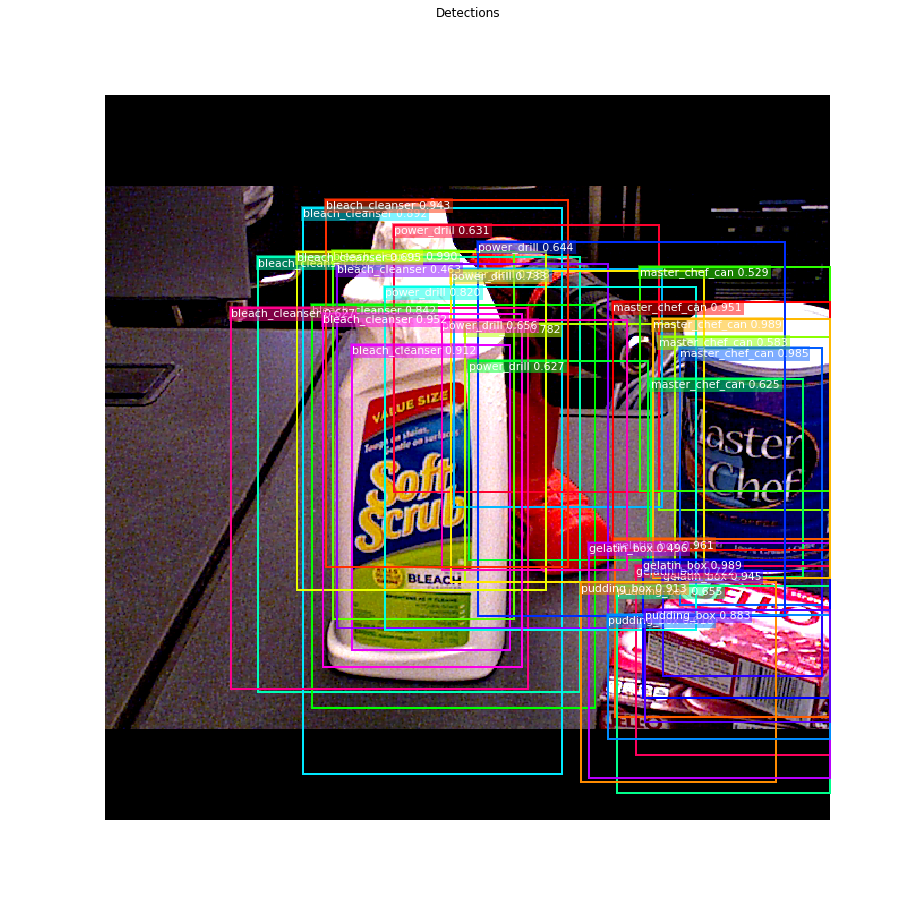

In [20]:
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = activations['rois'][0, :det_count]
# class_logits = class_logits[:det_count]
roi_class_ids = np.argmax(activations["mrcnn_class"][0], axis=1)
roi_scores = activations["mrcnn_class"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# TODO: I'm not sure if roi_scores[:det_count] is the same as detections[:, 5]
captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(det_class_ids, roi_scores[:det_count])]
visualize.draw_boxes(
    image[:, :, :3],
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections), title="Detections", captions=captions,
    ax=get_ax())


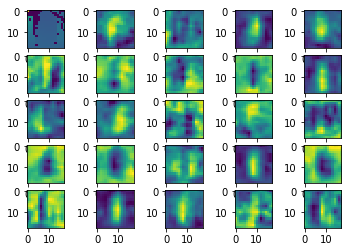

In [21]:
roi = 0
fig, axes = plt.subplots(5, 5)
for i, ax in enumerate(fig.axes):
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    if not i:
        ax.imshow(activations["roi_align_pose_depth"][0, roi, :, :, 0])
    else:
        ax.imshow(activations["roi_align_pose_image"][0, roi, :, :, i - 1])


In [22]:
roi_pc = o3d.PointCloud()
roi_pc.points = o3d.Vector3dVector(activations["pcl_list"][0, :det_count].reshape(-1, 3))
color_raw = o3d.read_image(info["path"])
depth_raw = o3d.read_image(info["depth"])
rgbd_im = o3d.create_rgbd_image_from_color_and_depth(
        color_raw, depth_raw, depth_scale=10000, convert_rgb_to_intensity=False)
camera = o3d.PinholeCameraIntrinsic()
camera.intrinsic_matrix = intrinsic_matrix
# camera = o3d.PinholeCameraIntrinsic(
#     o3d.PinholeCameraIntrinsicParameters.Kinect2DepthCameraDefault)
pcd = o3d.create_point_cloud_from_rgbd_image(rgbd_im, camera)
# pred_pc = o3d.PointCloud()
# pred_pc.points = o3d.Vector3dVector(activations["added_pred_models"].reshape(-1, 3))
# o3d.draw_geometries([roi_pc, pcd])

with open(config.XYZ_MODEL_PATH, "rb") as f:
    df = np.array(pkl.load(f), dtype=np.float32)
xyz_models = np.transpose(df, (0, 2, 1))
# num_xyz_points = xyz_models.shape[2]

# test that translations given by estimation branch are the ones used to calculate loss
pred_trans1 = activations["trans_reshape"]
pred_trans2 = np.reshape(pred_trans1, (-1, 1, 3, config.NUM_CLASSES))
# np.testing.assert_equal(pred_trans2, np.reshape(np.transpose(pred_trans1,
#                                                             [0, 1, 3, 2, 4]), (-1, 1, 3, config.NUM_CLASSES)))
pred_trans3 = np.transpose(pred_trans2, [0, 3, 1, 2])
np.testing.assert_equal(pred_trans3, activations["pose_pred_trans"])
tci = activations["pose_target_class_ids"]


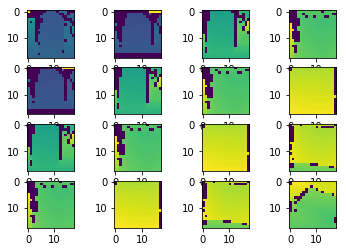

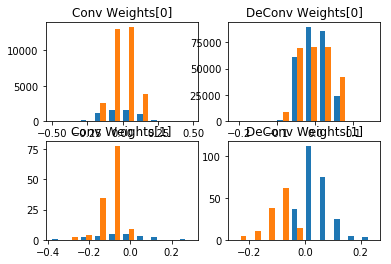

In [23]:
#visualize the cropped and resized depths
fig, ax = plt.subplots(4, 4)
roi_depth_images = activations["roi_align_pose_depth"][0]
for x, y in np.ndindex(ax.shape):
    ax[x, y].imshow(np.squeeze(roi_depth_images[x+y]))


#### equivalency tests

fig, ax = plt.subplots(2, 2)
ax[0, 0].hist([weights["mrcnn_mask_0"].flatten(), weights["trans_fc2_0"].flatten()])
ax[0, 0].set_title("Conv Weights[0]")
ax[0, 1].hist([weights["mrcnn_mask_deconv_0"].flatten(), weights["trans_fc1_0"].flatten()])
ax[0, 1].set_title("DeConv Weights[0]")
ax[1, 0].hist([weights["mrcnn_mask_1"].flatten(), weights["trans_fc2_1"].flatten()])
ax[1, 0].set_title("Conv Weights[1]")
ax[1, 1].hist([weights["mrcnn_mask_deconv_1"].flatten(), weights["trans_fc2_1"].flatten()])
ax[1, 1].set_title("DeConv Weights[1]")

assert np.array_equal(activations["pose_target_class_ids"][:det_count], det_class_ids)
assert np.array_equal(np.where(activations["target_class_ids"][0] > 0)[0], activations["pose_positive_ix"])
# y_true_r is equal to the rotation of the object in the meta-file plus the changes made during rescaling
# check that the "true" poses are the correct ones for the objects inside the rois
index = np.searchsorted(classes.reshape(-1), det_class_ids, sorter=np.argsort(classes.reshape(-1)))
det_class_indeces = np.take(np.argsort(classes.reshape(-1)), index, mode="clip")
# TODO: this only works for this specific dataset were the pad
for i in range(det_count):
    corresponding_pose = poses[:, :, det_class_indeces[i]].astype("float32")
    assert classes[det_class_indeces[i]][0] == activations["pose_target_class_ids"][i]
    np.testing.assert_allclose(activations["pose_y_true_r"][i], corresponding_pose[:3, :3], rtol=1e-5)
    np.testing.assert_allclose(activations["pose_y_true_t"][i],
                               np.expand_dims(corresponding_pose[:3, 3], axis=0), rtol=1e-5)
    concat_pose = np.concatenate([activations["pose_y_true_r"][i],
                                  np.transpose(activations["pose_y_true_t"], [0, 2, 1])[i]], axis=1)
    np.testing.assert_allclose(concat_pose, corresponding_pose, rtol=1e-5)
# check that the selected point clouds are the correct ones for the object inside the roi
# check that rois with the same gt_id have selected the same point_cloud
for i in np.unique(det_class_ids):
    ids = np.where(det_class_ids == i)[0]
    assert all_equal(activations["pose_pos_xyz_models"][ids])


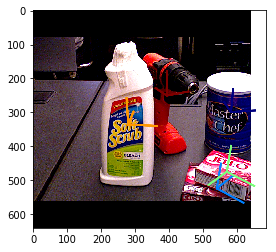

In [24]:
#TODO: check that the poses and translations and their groundtruths are on the same scale (rel. image, vs world?)

# transl is [n, 1, 3] and needs to be [N, 3, 1] to concatenate to [N, 3, 4] poses
concat_poses = np.concatenate([activations["pose_y_true_r"], np.transpose(activations["pose_y_true_t"], [0, 2, 1])], axis=2)
visualize.visualize_poses(image, concat_poses, activations["pose_positive_class_ids"], intrinsic_matrix_gt)


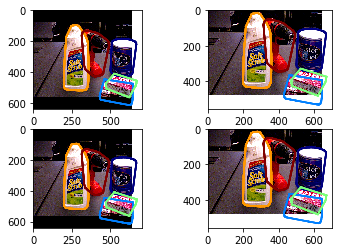

In [29]:

models = np.transpose(activations["pose_pos_xyz_models"], [0, 2, 1])
homogeneous_models = np.concatenate([models, np.tile([1], (models.shape[0], models.shape[1], 1))], axis=2)
trans_hom_models = np.matmul(concat_poses, np.transpose(homogeneous_models, [0, 2, 1])).transpose([0, 2, 1])
# this test fails sometimes with a mismatch of < 1e-3 %
# np.testing.assert_allclose(trans_hom_models, activations["added_target_models"], rtol=1e-3)
identity_poses = np.zeros_like(concat_poses)
identity_poses[:, 0, 0] = 1
identity_poses[:, 1, 1] = 1
identity_poses[:, 2, 2] = 1
fig, ax = plt.subplots(2, 2)

visualize.visualize_pointcloud_hulls(image, concat_poses, models,
                                     activations["pose_positive_class_ids"], intrinsic_matrix_gt, ax=ax[0, 0])
# visualize the target models, that are calculated using the gt_poses in the chamfer loss function
visualize.visualize_pointcloud_hulls(image, identity_poses, activations["added_target_models"],
                                     activations["pose_positive_class_ids"], intrinsic_matrix_gt, ax=ax[1, 0])
visualize.visualize_pointcloud_hulls(non_molded_im, concat_poses, models,
                                     activations["pose_positive_class_ids"], intrinsic_matrix, ax=ax[0, 1])
# visualize the target models, that are calculated using the gt_poses in the chamfer loss function
visualize.visualize_pointcloud_hulls(non_molded_im, identity_poses, activations["added_target_models"],
                                     activations["pose_positive_class_ids"], intrinsic_matrix, ax=ax[1, 1])


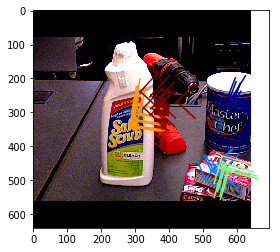

In [26]:
u, s, vh = np.linalg.svd(activations["pose_y_pred_r"])
r = np.matmul(u, vh)
# TODO: this should be the same somehow, but tf return the adjoint of v and np does not
# still they should be the same if tf.linalg.matmul(u,v, adjoint_b=True) is used, but its not
# np.testing.assert_allclose(r, activations["pose_pred_rot_svd_matmul"], rtol=1e-3)
concat_poses2 = np.concatenate([r,
                               np.transpose(activations["pose_y_pred_t"], [0, 2, 1])], axis=2)
visualize.visualize_poses(image, concat_poses2, activations["pose_positive_class_ids"], intrinsic_matrix_gt)


In [27]:
##### Check correctness of CalcRotMatrix
if "calcrotmatrix" in activations.keys():
    r_m = np.transpose(activations["rot_reshape"], [0, 1, 4, 3, 2])
    x_1 = r_m[:, :, :, 0, :]
    x_2 = r_m[:, :, :, 1, :]
    x_1 /= np.expand_dims(np.sqrt(np.sum(np.square(x_1), axis=3)), axis=-1)
    x_2 /= np.expand_dims(np.sqrt(np.sum(np.square(x_2), axis=3)), axis=-1)
    x_3 = np.cross(x_1, x_2)
    np.testing.assert_allclose(np.sqrt(np.sum(np.square(x_1), axis=3)),
                               np.ones((1, 100, 22)), rtol=1e-5)
    np.testing.assert_allclose(np.sqrt(np.sum(np.square(x_2), axis=3)),
                               np.ones((1, 100, 22)), rtol=1e-5)
    exceptions = []
    # TODO:
    # This fails for certain classes (but then for each roi) with slightly different rotations
    # Not sure if this is due to numerical issues because the differences are usually
    # of the scale 1e-3
    for i in range(100):
        for j in range(22):
            a = x_1[0, i, j]
            b = x_2[0, i, j]
            v = x_3[0, i, j]
            c = np.dot(a, b)
            v_cross = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]], dtype=np.float32)
            I = np.eye(3, dtype=np.float32)
            factor = 1 / (1 + c)
            rot = I + v_cross + np.dot(v_cross, v_cross) * factor
            rot_network = activations["calcrotmatrix"][0, i, :, :, j]
            try:
                np.testing.assert_allclose(rot.astype(np.float32), rot_network, atol=1e-5)
            except AssertionError:
                exceptions.append((i, j))


In [28]:
# rois = k.layers.Input((config.TRAIN_ROIS_PER_IMAGE, 4))
# P2 = k.layers.Input((160, 160, 256))
# P3 = k.layers.Input((80, 80, 256))
# P4 = k.layers.Input((40, 40, 256))
# P5 = k.layers.Input((20, 20, 256))
# depth_image = k.layers.Input((config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 1))
# image_meta_in = k.layers.Input(image_meta.shape)
# intrinsic_matrices = k.layers.Input(intrinsic_matrix.shape)
# trans, rot = build_fpn_pointnet_pose_graph(rois, [P2, P3, P4, P5], depth_image, image_meta_in, intrinsic_matrices, config)
# 
# #
# optimizer = k.optimizers.SGD(
#             lr=config.LEARNING_RATE, momentum=config.LEARNING_MOMENTUM,
#             clipnorm=config.GRADIENT_CLIP_NORM)
# # optimizer = k.optimizers.Nadam(lr=0.0001)
# 
# target_poses = activations["pose_target_poses"].reshape((config.IMAGES_PER_GPU, config.TRAIN_ROIS_PER_IMAGE, 4, 4))
# target_poses_inp = k.layers.Input(batch_shape=target_poses.shape)
# target_class_ids = activations["pose_target_class_ids"].reshape((config.IMAGES_PER_GPU, -1))
# target_class_ids_inp = k.layers.Input(batch_shape=target_class_ids.shape)
# # because keras is retarded
# target_poses_inp._keras_shape = (None, None, 4, 4)
# xyz = k.layers.Input(tensor=tf.constant(xyz_models))
# loss = mrcnn_pose_loss_graph_keras(target_poses_inp, target_class_ids_inp, trans, rot, xyz, config, 2620)
# inputs = [rois, P2, P3, P4, P5, depth_image, image_meta_in, intrinsic_matrices, target_poses_inp, target_class_ids_inp, xyz]
# # loss_model = k.Model(inputs=inputs, outputs=[loss])
# # y_pred_t = loss_model.get_layer("mrcnn_pose_loss/y_pred_t")
# # y_pred_r = loss_model.get_layer("mrcnn_pose_loss/y_pred_r")
# test_model = k.Model(inputs=inputs, outputs=[trans, rot, loss])
# def custom_loss(y_true, y_pred):
#     return y_pred
# test_model.compile(optimizer, loss=custom_loss, loss_weights=[0, 0, 1])
# x = [activations["rois"], activations["fpn_p2"], activations["fpn_p3"],
#               activations["fpn_p4"], activations["fpn_p5"], image[np.newaxis, :, :, 3, np.newaxis],
#              np.expand_dims(image_meta, 0), np.expand_dims(intrinsic_matrix_gt, 0), target_poses, target_class_ids]
# tensorboard = k.callbacks.TensorBoard(histogram_freq=1, write_grads=True, write_images=True,
#                                       write_graph=True)
# val_rot = activations["target_poses"][:, :, :3, :3]
# val_trans = np.expand_dims(activations["target_poses"][:, :, :3, 3], -1)
# # for the TensorboardCallback there is a check that all inputs have the same batch number and all inputs
# # are given for validation. This is not possible with deleting the xyz_input (which is constant) from
# # the inputs
# test_model.inputs = test_model.inputs[:-1]
# # test_model.metrics_tensors += [trans, rot]
# class monitor_translation_during_training(k.callbacks.Callback):
#     def __init__(self, x):
#         self.losses = None
#         self.loss_translations = None
#         self.translations = None
#         self.loss_rotations = None
#         self.rotations=None
# 
#         self.x = x
# 
#         self.pred_func = None
# 
# 
#     def on_train_begin(self, logs=None):
#         if logs is None:
#             logs = {}
#         outputs = [self.model.get_layer("mrcnn_pose_loss/y_pred_t").output,
#                    self.model.get_layer("mrcnn_pose_loss/y_pred_r").output]
#         target_outputs = [self.model.get_layer("mrcnn_pose_loss/y_true_t").output,
#                    self.model.get_layer("mrcnn_pose_loss/y_true_r").output]
#         self.pred_func = k.backend.function(inputs=self.model.inputs, outputs=outputs)
#         self.target_func = k.backend.function(inputs=self.model.inputs, outputs=target_outputs)
#         trans, rot = self.target_func(self.x)
#         self.target_trans = trans
#         self.target_rot = rot
#         self.losses=[]
#         self.translations =[]
#         self.rotations = []
#         self.loss_translations = []
#         self.loss_rotations = []
# 
#     def on_epoch_end(self, epoch, logs=None):
#         if logs is None:
#             logs = {}
#         predictions = self.model.predict_on_batch(self.x)
#         loss_preds = self.pred_func(x)
#         self.translations.append(predictions[0][0])
#         self.rotations.append(predictions[1][0])
#         self.loss_translations.append(loss_preds[0])
#         self.loss_rotations.append(loss_preds[1])
#         self.losses.append(predictions[2])
#         return
# 
# value_monitor = monitor_translation_during_training(x)
# # hist = test_model.fit(x, [np.zeros((1, )), np.zeros((1, )), np.zeros((1, ))], batch_size=30, epochs=150,
# #                       callbacks=[tensorboard, value_monitor],
# #                       validation_data=(x,[np.expand_dims(val_trans, -1), np.expand_dims(val_rot, -1), np.zeros(1,)]))
#                       # validation_split=1.)
# 
# from mpl_toolkits.mplot3d import Axes3D
# trans_steps = []
# rot_steps = []
# obj_id = 1
# for step in range(len(value_monitor.loss_translations)):
#     trans_steps.append(value_monitor.loss_translations[step][obj_id])
#     u, s, vh = np.linalg.svd(value_monitor.loss_rotations[step][obj_id])
#     r = np.matmul(u, vh)
#     rot_steps.append(r)
# trans_steps = np.squeeze(np.array(trans_steps))
# rot_steps = np.array(rot_steps)
# t_trans = np.squeeze(value_monitor.target_trans[obj_id])
# t_rot = np.squeeze(value_monitor.target_rot[obj_id])
# 
# 
# def make_quiver_plot(trans, rot, target_trans, target_rot, plot_arrows=True):
#     origin = np.array([0, 0, 0])
#     x = np.array([0.5, 0, 0])
#     y = np.array([0, 0.5, 0])
#     z = np.array([0, 0, 0.5])
#     X = trans[:, 0]
#     Y = trans[:, 1]
#     Z = trans[:, 2]
#     r_x = np.matmul(rot, x)
#     r_y = np.matmul(rot, y)
#     r_z = np.matmul(rot, z)
#     t_x = np.matmul(target_rot, x)
#     t_y = np.matmul(target_rot, y)
#     t_z = np.matmul(target_rot, z)
#     U_x = r_x[:, 0]
#     U_y = r_y[:, 0]
#     U_z = r_z[:, 0]
#     V_x = r_x[:, 1]
#     V_y = r_y[:, 1]
#     V_z = r_z[:, 1]
#     W_x = r_x[:, 2]
#     W_y = r_y[:, 2]
#     W_z = r_z[:, 2]
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot(trans[:, 0], trans[:, 1], zs=trans[:, 2])
#     if plot_arrows:
#         ax.quiver(X, Y, Z, U_x, V_x, W_x, colors=[1, 0, 0, 1])
#         ax.quiver(X, Y, Z, U_y, V_y, W_y, colors=[0, 1, 0, 1])
#         ax.quiver(X, Y, Z, U_z, V_z, W_z, colors=[1, 0, 1, 1])
#     ax.scatter(target_trans[0], target_trans[1], zs=target_trans[2], c="r")
#     ax.quiver(target_trans[0], target_trans[1], target_trans[2],
#               t_x[0], t_x[1], t_x[2], colors=[1, 0, 0, 1])
#     ax.quiver(target_trans[0], target_trans[1], target_trans[2],
#               t_y[0], t_y[1], t_y[2], colors=[0, 1, 0, 1])
#     ax.quiver(target_trans[0], target_trans[1], target_trans[2],
#               t_z[0], t_z[1], t_z[2], colors=[1, 0, 1, 1])
# 
# make_quiver_plot(trans_steps, rot_steps, t_trans, t_rot, False)
# outputs = [test_model.get_layer("mrcnn_pose_loss/y_pred_t").output,
#            test_model.get_layer("mrcnn_pose_loss/y_pred_r").output]
# target_outputs = [test_model.get_layer("mrcnn_pose_loss/y_true_t").output,
#                   test_model.get_layer("mrcnn_pose_loss/y_true_r").output]
# pred_func = k.backend.function(inputs=test_model.inputs, outputs=outputs)
# target_func = k.backend.function(inputs=test_model.inputs, outputs=target_outputs)
# predictions = pred_func(x)
# u, s, vh = np.linalg.svd(predictions[1])
# r = np.matmul(u, vh)
# concat_poses2 = np.concatenate([r,
#                                np.transpose(predictions[0], [0, 2, 1])], axis=2)
# visualize.visualize_poses(image, concat_poses2, activations["pose_positive_class_ids"], intrinsic_matrix)
